In [1]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import nglui.statebuilder as ngstbld

# # this is the EM specific package for querying the EM data
from caveclient import CAVEclient

from sklearn.decomposition import PCA
from numpy.random import default_rng

import umap

import cloudvolume
import fanc
import numpy as np
import navis
import pcg_skel
#from FANC_auto_recon.segmentation import authentication_utils
from meshparty import trimesh_io, trimesh_vtk, meshwork
#from meshparty import skeletonize, skeleton_io, skeleton

%load_ext autoreload
%autoreload 2

query timestamp: 2023-10-16 00:00:00 (1697439600.0)


In [2]:
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)
cv = cloudvolume.CloudVolume(client.info.get_datastack_info()['segmentation_source'], use_https=True)


# Skeleltonize + cluster attempt


In [3]:
mn_table = client.materialize.query_table('motor_neuron_table_v7')

In [4]:
mn_table
mn_mi = connectome_create.mn_multi_index(mn_table)
mn_table.index = mn_mi
mn_table

id  \
side nerve     segment function muscle                                             rank segID                     
L    Accessory thorax  stance   sternal_posterior_rotator_miller_32                0    648518346489802071  279   
                                                                                        648518346490738941  280   
                                                                                        648518346488854257  281   
                                pleural_remotor_and_abductor_miller_29             0    648518346489076201  283   
                       swing    sternal_adductor_miller_miller_in_thorax_miller_33 0    648518346478125293  285   
...                                                                                                         ...   
R    Ventral   coxa    flex     trochanter_flexor                                  Vn   648518346494836658  408   
               thorax  extend   tergotrochanter                                    0    648518346494871218  410   
                                                                                   2    648518346513954073  412   
                                extracoxal_trochanter_depressor                    Vn   648518346486265480  414   
                       swing    sternal_anterior_rotator_miller_31                 0    648518346507171144  416   

                                                                                                                                    created  \
side nerve     segment function muscle                                             rank segID                                                 
L    Accessory thorax  stance   sternal_posterior_rotator_miller_32                0    648518346489802071 2022-05-02 19:38:09.218288+00:00   
                                                                                        648518346490738941 2022-05-02 19:38:09.326692+00:00   
                                                                                        648518346488854257 2022-05-02 19:38:09.341395+00:00   
                                pleural_remotor_and_abductor_miller_29             0    648518346489076201 2022-05-02 19:38:09.368249+00:00   
                       swing    sternal_adductor_miller_miller_in_thorax_miller_33 0    648518346478125293 2022-05-02 19:38:09.395668+00:00   
...                                                                                                                                     ...   
R    Ventral   coxa    flex     trochanter_flexor                                  Vn   648518346494836658 2022-05-02 19:38:11.128153+00:00   
               thorax  extend   tergotrochanter                                    0    648518346494871218 2022-05-02 19:38:11.152189+00:00   
                                                                                   2    648518346513954073 2022-05-02 19:38:11.175275+00:00   
                                extracoxal_trochanter_depressor                    Vn   648518346486265480 2022-05-02 19:38:11.199095+00:00   
                       swing    sternal_anterior_rotator_miller_31                 0    648518346507171144 2022-05-02 19:38:11.223208+00:00   

                                                                                                            superceded_id  \
side nerve     segment function muscle                                             rank segID                               
L    Accessory thorax  stance   sternal_posterior_rotator_miller_32                0    648518346489802071            NaN   
                                                                                        648518346490738941            NaN   
                                                                                        648518346488854257            NaN   
                                pleural_remotor_and_abductor_miller_29             0    648518346489076201            NaN   
   

In [5]:
left_mn_list = mn_table.loc['L','pt_root_id'].to_list()
len(left_mn_list)
i = left_mn_list[0]
All = slice(None)
mn_table.loc[(All,All,All,All,All,All,i),'cell_type'].values[0]

'sternal_posterior_rotator_in_thorax_miller_32'

In [6]:

skel_list = []
cnt=0
for i in left_mn_list:
    print('{} - segID is {}: {}'.format(cnt,i,mn_table.loc[(All,All,All,All,All,All,i),'cell_type'].values[0]))
    skel = pcg_skel.coord_space_skeleton(i,client,cv=cv)
    navis_skel = fanc.skeletonize.mp_to_navis(skel)
    skel_list.append(navis_skel)
    cnt+=1

skel_list_navis = navis.NeuronList(skel_list) 
dps = navis.make_dotprops(skel_list_navis) / 1000

#test, should take awhile
# san_s = skel_all_neurons(left_mn_list)
# dps, skels = san_s[0], san_s[1]

0 - segID is 648518346489802071: sternal_posterior_rotator_in_thorax_miller_32
1 - segID is 648518346490738941: sternal_posterior_rotator_in_thorax_miller_32
2 - segID is 648518346488854257: sternal_posterior_rotator_in_thorax_miller_32
3 - segID is 648518346489076201: pleural_remotor_and_abductor_in_thorax_miller_29
4 - segID is 648518346478125293: sternal_adductor_miller_in_thorax_miller_33
5 - segID is 648518346494359922: trochanter_flexor_in_coxa_AcPst
6 - segID is 648518346466832494: trochanter_flexor_in_coxa_Ac
7 - segID is 648518346478992848: sternal_posterior_rotator_in_thorax_miller_32
8 - segID is 648518346479077839: pleural_remotor_and_abductor_in_thorax_miller_29
9 - segID is 648518346494315911: trochanter_flexor_in_coxa_AcPst
10 - segID is 648518346490542172: trochanter_flexor_in_coxa_Ac
11 - segID is 648518346479840662: trochanter_flexor_in_coxa_Ac
12 - segID is 648518346517437482: tergopleural_promotor_pleural_promotor_in_thorax_miller_28_30
13 - segID is 648518346487756

Dotprops:   0%|          | 0/69 [00:00<?, ?it/s]

Dividing:   0%|          | 0/69 [00:00<?, ?it/s]

In [7]:
aba = navis.nblast_allbyall(dps, progress=False)
# aba.set_axis(left_mn_list, axis=1,inplace=True)

In [8]:
aba.index = mn_table.loc[('L',All,All,All,All,All,All,All),:].index
aba.columns = aba.index

In [9]:
aba = aba.loc[utils.sort_segment_fcn_index(aba.columns),utils.sort_segment_fcn_index(aba.columns)]
# aba.columns

In [10]:
aba_mean = (aba + aba.T) / 2
aba_dist = 1 - aba_mean
aba_dist

side                                                                                                                                                           L  \
nerve                                                                                                                                                     Dorsal   
segment                                                                                                                                                   thorax   
function                                                                                                                                                   swing   
muscle                                                                                                       tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                                           0   
segID                                                                                                                                         648518346517437482   
side nerve   segment function muscle                                             rank     segID                                                                    
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346517437482                                           0.000000    
                                                                                          648518346487756866                                           0.592729    
                                                                                          648518346491659326                                           0.555278    
                                                                                          648518346517827432                                           0.584888    
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346487504531                                           0.645251    
...                                                                                                                                                          ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393                                           0.816363    
                     unknown  tarsus_unidentified                                Bslow    648518346480904925                                           0.864698    
                                                                                 A1       648518346489767549                                           0.801184    
                                                                                 A2       648518346495467855                                           0.793807    
                                                                                 E        648518346486741295                                           0.754120    

side                                                                                                                             \
nerve                                                                                                                             
segment                                                                                                                           
function                                                                                                                          
muscle                                                                                                                            
rank                                                                                                                              
segID                                                                                            

In [11]:
aba_mean

side                                                                                                                                                           L  \
nerve                                                                                                                                                     Dorsal   
segment                                                                                                                                                   thorax   
function                                                                                                                                                   swing   
muscle                                                                                                       tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                                           0   
segID                                                                                                                                         648518346517437482   
side nerve   segment function muscle                                             rank     segID                                                                    
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346517437482                                           1.000000    
                                                                                          648518346487756866                                           0.407271    
                                                                                          648518346491659326                                           0.444722    
                                                                                          648518346517827432                                           0.415112    
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346487504531                                           0.354749    
...                                                                                                                                                          ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393                                           0.183637    
                     unknown  tarsus_unidentified                                Bslow    648518346480904925                                           0.135302    
                                                                                 A1       648518346489767549                                           0.198816    
                                                                                 A2       648518346495467855                                           0.206193    
                                                                                 E        648518346486741295                                           0.245880    

side                                                                                                                             \
nerve                                                                                                                             
segment                                                                                                                           
function                                                                                                                          
muscle                                                                                                                            
rank                                                                                                                              
segID                                                                                            

In [12]:
min_ = np.min(np.tril(aba_mean))
aba_mean_mat = aba_mean.values
aba_mean_mat
np.fill_diagonal(aba_mean_mat,val=min_)



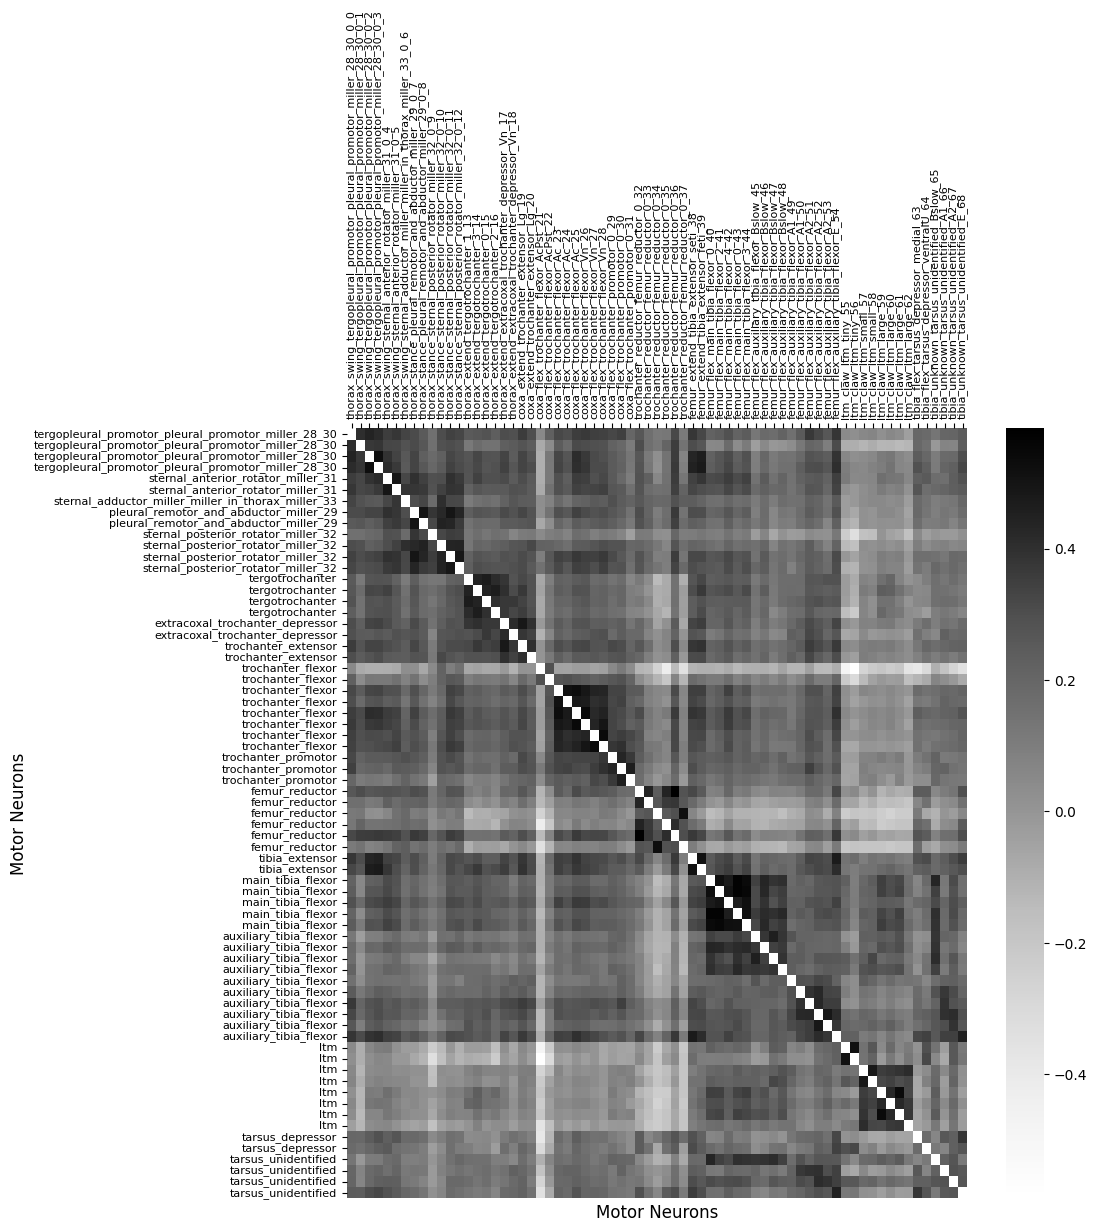

In [13]:

lbls = utils.mn_labels(aba.index.to_frame(),depth='rank')


fig, ax = plt.subplots( 1, 1, figsize=(10,10))
ax = sns.heatmap(aba_mean_mat, xticklabels=lbls, yticklabels=aba.index.get_level_values('muscle').to_list(),cmap=plt.get_cmap('Greys'),ax=ax)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
# cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =12)
plt.ylabel('Motor Neurons', fontsize =12)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.show()

fig.savefig('./figpanels/nblast_all_grayscale.svg',format='svg')

In [15]:
import utils
mn_mi_df = aba.index.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_morpho_pools()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df

side  \
side nerve   segment function muscle                                             rank     segID                     
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346517437482    L   
                                                                                          648518346487756866    L   
                                                                                          648518346491659326    L   
                                                                                          648518346517827432    L   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346487504531    L   
...                                                                                                           ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393    L   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925    L   
                                                                                 A1       648518346489767549    L   
                                                                                 A2       648518346495467855    L   
                                                                                 E        648518346486741295    L   

                                                                                                                nerve  \
side nerve   segment function muscle                                             rank     segID                         
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346517437482   Dorsal   
                                                                                          648518346487756866   Dorsal   
                                                                                          648518346491659326   Dorsal   
                                                                                          648518346517827432   Dorsal   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346487504531  Ventral   
...                                                                                                               ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393      Leg   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925      Leg   
                                                                                 A1       648518346489767549      Leg   
                                                                                 A2       648518346495467855      Leg   
                                                                                 E        648518346486741295      Leg   

                                                                                                             segment  \
side nerve   segment function muscle                                             rank     segID                        
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346517437482  thorax   
                                                                                          648518346487756866  thorax   
                                                                                          648518346491659326  thorax   
                                                                                          648518346517827432  thorax   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346487504531  thorax   
...                                                                                                              ...   
     Leg     tibia   flex     tarsus_depressor       

array(['coxa_swing', 'coxa_swing', 'coxa_swing', ..., 'tibia_ta_flex_C',
       'tibia_ta_flex_C', 'tibia_ta_flex_C'], dtype=object)

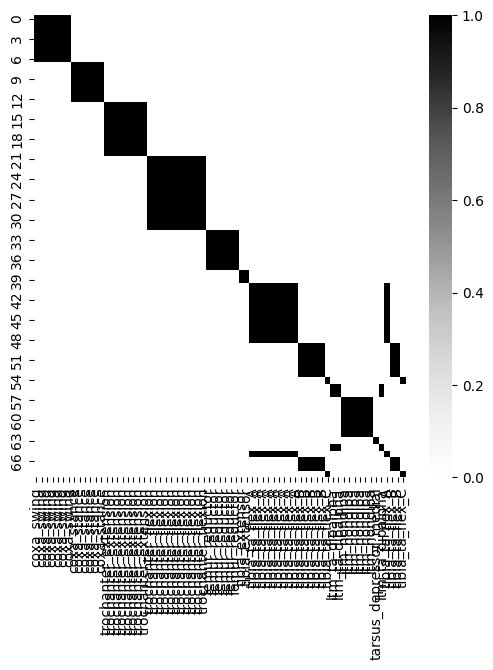

In [16]:
tril_mask = np.full((aba_mean_mat.shape[0], aba_mean_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((aba_mean_mat.shape[0], aba_mean_mat.shape[1]), False, dtype=bool)
i_index = np.full((aba_mean_mat.shape[0], aba_mean_mat.shape[1]), 0, dtype=int)
j_index = np.full((aba_mean_mat.shape[0], aba_mean_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
pool_arr.reshape(-1)

In [18]:
aba_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }


In [20]:
nblast_compare_df = pd.DataFrame.from_dict(data = aba_dict,orient='columns')


nblast_compare_df['nblast_vals'] = aba_mean_mat.reshape(-1)
    
# # get rid of upper triangle
nblast_compare_df = nblast_compare_df.loc[nblast_compare_df.lower_tri.to_numpy()]
nblast_compare_df


,pool,same_pool,lower_tri,i_index,j_index,nblast_vals
69,coxa_swing,True,True,1,0,0.407271
138,coxa_swing,True,True,2,0,0.444722
139,coxa_swing,True,True,2,1,0.372892
207,coxa_swing,True,True,3,0,0.415112
208,coxa_swing,True,True,3,1,0.386175
...,...,...,...,...,...,...
4755,tibia_ta_flex_C,False,True,68,63,0.385608
4756,tibia_ta_flex_C,False,True,68,64,0.275259
4757,tibia_ta_flex_C,False,True,68,65,0.119699
4758,tibia_ta_flex_C,False,True,68,66,0.262332


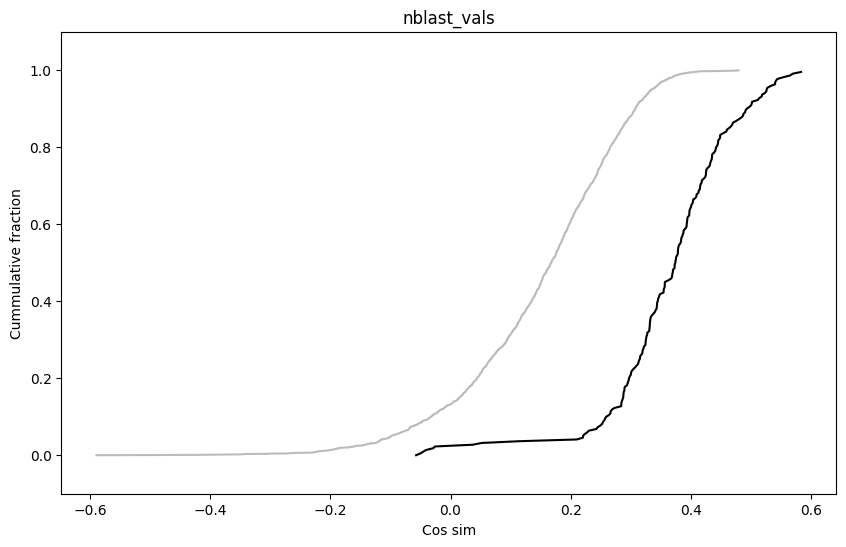

In [25]:
import scipy

cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

cnt=cnt+1
idx = 'nblast_vals'

# def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylim([-.1, 1.1])
# ax.set_xlim([.945, .96])
# ax.set_xlim([0, 1])
ax.set_ylabel('Cummulative fraction')
ax.set_xlabel('Cos sim')
ax.set_title(idx)

x_outofpool = nblast_compare_df.loc[~nblast_compare_df['same_pool'],idx]

y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

x_inpool = nblast_compare_df.loc[nblast_compare_df['same_pool'],idx]

y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
ax.plot(sorted(x_inpool),y,color='#000000')

fig.savefig('./figpanels/cdf_nblast_within_across.svg',format='svg')

ks_val = scipy.stats.kstest(x_inpool,x_outofpool)
mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

# pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
# p=1-pct_below_actual
# ax.text(.94,.5,'p = {:.5f}'.format(p))

# if not fn is None:
#     fig.savefig('./figpanels/{}.eps'.format(fn),format='eps')

In [26]:
mwu_val

[0.9140832121782263]

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns

set_link_color_palette([mcl.to_hex(c) for c in sns.color_palette('muted', 10)])

# To generate a linkage, we have to bring the matrix from square-form to vector-form
aba_vec = squareform(aba_dist, checks=False)

# Generate linkage
Z = linkage(aba_vec, method='ward')

# Plot a dendrogram
dn = dendrogram(Z, labels=aba_mean.columns)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

sns.despine(trim=True, bottom=True)

In [ ]:
fig, ax = navis.plot2d(skel_list[40])
ax.azim, ax.elev = -10,90
ax.dist = 6
plt.show()

In [ ]:
import math
# Generate clusters
from scipy.cluster.hierarchy import fcluster
cl = fcluster(Z, t=1.25, criterion='distance')
n_clusters = max(cl)
rows = 2
cols = math.ceil(n_clusters / 2)
fig, axes = plt.subplots(rows, cols,
                         figsize=(20, 5 * cols))
# Flatten axes
axes = [ax for l in axes for ax in l]
# Generate colors
pal = sns.color_palette('muted', n_clusters)
for i in range(n_clusters):
    ax = axes[i]
    ax.set_title(f'cluster {i + 1}')
    # Get the neurons in this cluster
    this = dps[cl == (i + 1)]
    print(this.name)
    navis.plot2d(this, method='2d', ax=ax, color=pal[i], lw=1.5, view=('+x', '-y'), alpha=.5)
for ax in axes:
    ax.set_aspect('equal')
    ax.set_axis_off()